In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from collections import Counter
from helpers import sql

warnings.filterwarnings('ignore')

# pandas formatting
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', 200)
pd.set_option('display.float_format', '{:.1f}'.format)

In [2]:
requests = sql("""
    SELECT * FROM csas2_csasrequest;
""", database='dmapps_250723', disambiguate=False)

request_reviews = sql("""
    SELECT * FROM csas2_csasrequestreview;
""", database='dmapps_250723', disambiguate=False)

processes = sql("""
    SELECT * FROM csas2_process
        JOIN csas2_csasoffice ON csas2_process.lead_office_id = csas2_csasoffice.id
        JOIN shared_models_region ON csas2_csasoffice.region_id = shared_models_region.id;
""", database='dmapps_250723', disambiguate=False)
n_office = 7
n_region = 9
processes.columns = (
    [x for x in processes.columns[:-(n_office + n_region)]] 
    + ['office_' + x for x in processes.columns[-(n_office + n_region):-n_region]]
    + ['region_' + x for x in processes.columns[-n_region:]]
)

tor = sql("""
    SELECT * FROM csas2_termsofreference;
""", database='dmapps_250723')
tor["year"] = tor.created_at.dt.year

meetings = sql("""
    SELECT * FROM csas2_meeting;
""", database='dmapps_250723', disambiguate=False)
meetings["year"] = meetings.created_at.dt.year

invitees = sql("""
    SELECT
        csas2_invitee.status AS invitee_status,
        invitation_sent_date, meeting_id, person_id,
        region_id, comments, affiliation, job_title_en, job_title_fr,
        created_at AS meeting_created, updated_at AS meeting_updated, location AS meeting_location
    FROM csas2_invitee 
    JOIN csas2_meeting ON csas2_meeting.id = csas2_invitee.meeting_id;
""", database='dmapps_250723', disambiguate=False)
invitees['year'] = invitees.meeting_created.dt.year

documents =  sql("""
    SELECT * FROM csas2_document
        JOIN csas2_documenttype ON csas2_document.document_type_id = csas2_documenttype.id
        JOIN csas2_documenttracking ON csas2_documenttracking.document_id = csas2_document.id;
""", database='dmapps_250723', disambiguate=False)
n_doctype = 8
n_tracking = 52
documents.columns = (
    [x for x in documents.columns[:-(n_doctype + n_tracking)]] 
    + ['doctype_' + x for x in documents.columns[-(n_doctype + n_tracking):-n_tracking]]
    + ['tracking_' + x for x in documents.columns[-n_tracking:]]
)

changelog = sql("""
    SELECT * FROM csas2_changelog;
""", database='dmapps_250723', disambiguate=False) 

# Helper Functions

In [3]:
def null_heatmap(df, figsize=(4,12), by_year=True):
    if by_year and 'created_at' in df.columns:
        df_plot = df.copy()
        df_plot['year'] = df_plot['created_at'].dt.year
        yearly_data = df_plot.groupby('year').apply(lambda x: x.notna().mean()).T
        
        plt.figure(figsize=figsize)
        sns.heatmap(yearly_data, annot=True, fmt='.0%', cmap='RdBu', cbar=False, vmin=0.2, vmax=0.8)
        plt.tick_params(labelbottom=False)
        plt.show()
    else:
        plt.figure(figsize=figsize)
        sns.heatmap(df.notna().mean().to_frame(), annot=True, fmt='.0%', cmap='RdBu', cbar=False, vmin=0.2, vmax=0.8)
        plt.tick_params(labelbottom=False)
        plt.show()
    
def stringify_json_values(json_str):
    try:
        return {k: str(v) for k, v in json.loads(json_str).items()}
    except TypeError:
        return None
    
display_cols = ['count', 'mean', '2.5%', '16%', '50%', '84%', '97.5%']

# Requests

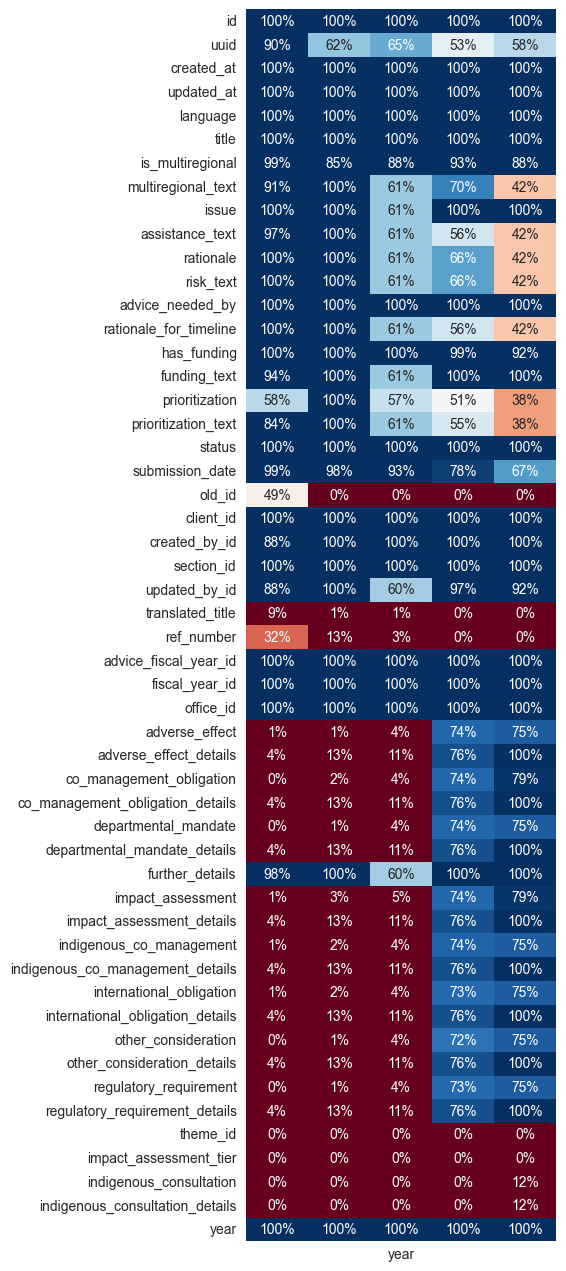

In [4]:
null_heatmap(requests, figsize=(4,16))

# CSAS Reviews

In [5]:
new_reviews = request_reviews[request_reviews.sufficient_data.notna()].copy().reset_index(drop=True)

review_cols = [
    'id', 'decision',
    'is_feasible', 'is_valid', 
    'science_question', 'specific_advice_required', 'lit_review', 'new_advice',
    'sufficient_capacity', 'sufficient_data', 'sufficient_time',
]

new_reviews['is_applicable_predicted'] = (
        (new_reviews.science_question == 1) & 
        (new_reviews.specific_advice_required == 1) &
        (new_reviews.lit_review == 0) &
        (new_reviews.new_advice == 0)
)
new_reviews['is_feasible_predicted'] = (
        (new_reviews.sufficient_capacity == 1) & 
        (new_reviews.sufficient_data == 1) &
        (new_reviews.sufficient_time == 1)
)

In [6]:
# is this ever different than predicted?
(new_reviews['is_feasible_predicted'] == new_reviews['is_feasible']).value_counts()

True    214
Name: count, dtype: int64

In [7]:
(new_reviews['is_applicable_predicted'] == new_reviews['is_valid']).value_counts()
# hmmmm


True     212
False      2
Name: count, dtype: int64

In [8]:
# looks fine, don't need to predict the columns
new_reviews.loc[~(new_reviews['is_applicable_predicted'] == new_reviews['is_valid']), review_cols].T

,54,110
id,1002.0,1202.0
decision,1.0,NaN
is_feasible,1.0,1.0
is_valid,NaN,NaN
science_question,NaN,NaN
specific_advice_required,NaN,NaN
lit_review,NaN,NaN
new_advice,NaN,NaN
sufficient_capacity,1.0,1.0
sufficient_data,1.0,1.0


In [9]:
# however, we should drop these so they don't mess with calculations
new_reviews = new_reviews[(new_reviews['is_applicable_predicted'] == new_reviews['is_valid'])]

In [10]:
review_rec_cols = [
    'id', 'decision',
    'is_feasible', 'is_valid', 
]
new_reviews['decision_matches_recommended'] = (
    ((new_reviews.decision == 1) & (new_reviews.is_feasible == 1) & (new_reviews.is_valid == 1)) |
    ((new_reviews.decision != 1) & ((new_reviews.is_feasible == 0) | (new_reviews.is_valid == 0)))
)

In [11]:
new_reviews['decision_matches_recommended'].value_counts()

decision_matches_recommended
True     181
False     31
Name: count, dtype: int64

In [12]:
new_reviews.loc[~new_reviews['decision_matches_recommended'], 'decision'].value_counts()

decision
1.0    22
3.0     3
2.0     2
Name: count, dtype: int64

In [13]:
# why are we screening in infeasible requests?

pd.DataFrame(new_reviews.loc[
    ((~new_reviews['decision_matches_recommended']) & (new_reviews.decision == 1)), 
    'override_reason'
].unique(), columns=['explanation']).sort_values('explanation').reset_index(drop=True)

,explanation
0,"If data becomes available, this request will be feasible and we can complete this request. Sea scallop (ranking 2) is prioritized over sea cucumber (ranking 3)."
1,Screened in but capacity and time are limiting factors
2,"TMM - due to time required, should be deferred to 26/27."
3,from Sarah Deller - priority has changed for SARP; from Andrew Taylor - Science will not have data for 2025/26
4,meeting now scheduled
5,plan are underway - work will begin in 2023-24
6,refer to recommendation explanation
7,"refer to recommendation explanation. no answers in spreadsheet to whether there is sufficient capacity, data or time,"
8,refer to the recommendation explanation
9,screen in/defer


# Processes

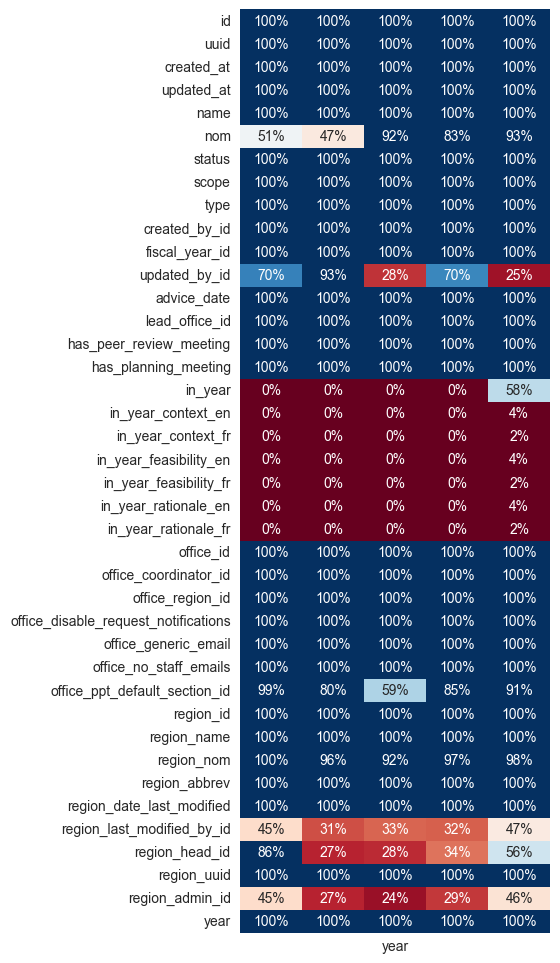

In [14]:
null_heatmap(processes)

# ToR

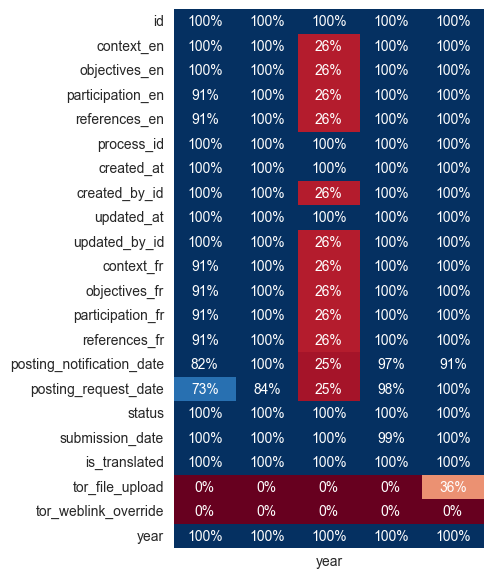

In [15]:
# approved ToR
null_heatmap(tor[tor.status>=35], figsize=(4, 7))

# Meetings

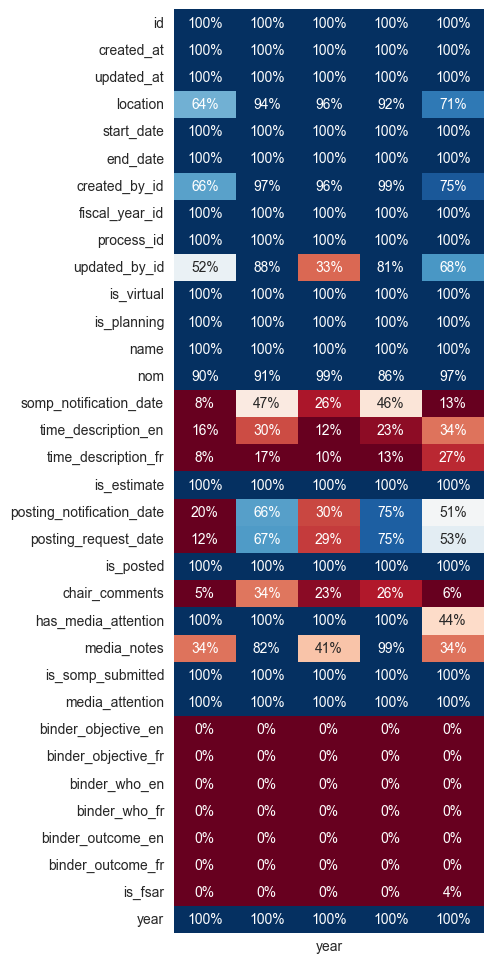

In [16]:
null_heatmap(meetings)

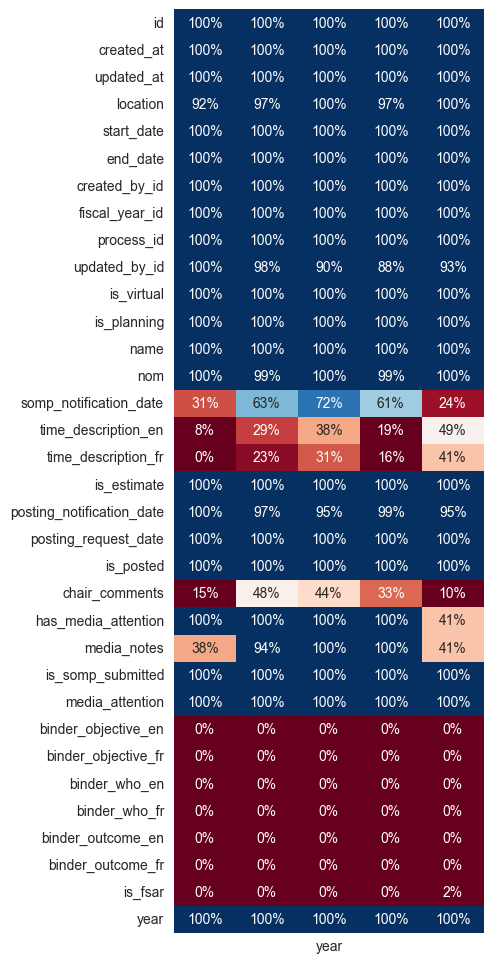

In [17]:
null_heatmap(meetings[meetings.posting_request_date.notna()])

# Invitees

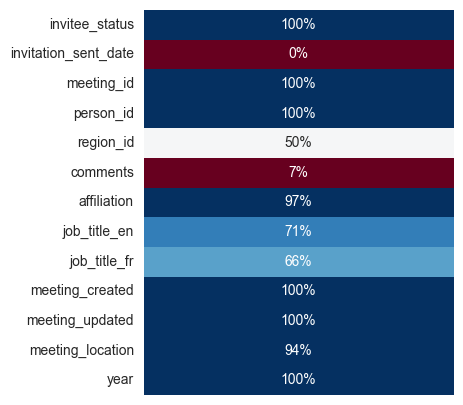

In [18]:
null_heatmap(invitees, figsize=(4, 5))

In [19]:
# invitee stats? need to break it down more
pd.DataFrame(invitees.meeting_id.value_counts()).describe()

,count
count,551.0
mean,8.8
std,12.2
min,1.0
25%,3.0
50%,5.0
75%,7.0
max,75.0


In [20]:
percentiles=[0.16, 0.84, 0.025, 0.975, 0.0015, 0.9985]

pd.DataFrame(invitees.groupby('year').meeting_id.value_counts().unstack(level=0)).describe(percentiles=percentiles).T[display_cols]

# TODO: compliance is definitely dropping in this module, year on year - compare current version versus 2021 version to see if anything new is added

,count,mean,2.5%,16%,50%,84%,97.5%
year,,,,,,,
2021,68.0,12.1,1.0,2.0,5.0,27.6,63.6
2022,163.0,8.1,1.0,3.0,4.0,12.0,41.8
2023,117.0,10.7,2.0,3.0,5.0,12.4,53.3
2024,133.0,7.5,1.3,3.0,5.0,10.0,36.7
2025,70.0,6.1,2.0,3.0,4.0,7.0,24.0


In [21]:
# how many are external?
invitees['is_dfo'] = (invitees.affiliation.str.upper().str.contains("DFO")) | (invitees.affiliation.str.upper().str.contains("MPO"))
invitees['is_dfo'].value_counts()

is_dfo
True     3514
False    1308
Name: count, dtype: int64

### including meetings with zero invitees

In [22]:
# make sure to add meetings with zero invitees, to not skew counts

print('\nStatistics - Number of Invitees')
all_invitees = invitees.groupby('year').meeting_id.value_counts()
all_meetings_years = meetings.set_index(['year', 'id']).index
all_invitees = all_invitees.reindex(all_meetings_years, fill_value=0)
pd.DataFrame(all_invitees.unstack(level=0)).describe(percentiles=percentiles).T[display_cols]


Statistics - Number of Invitees


,count,mean,2.5%,16%,50%,84%,97.5%
year,,,,,,,
2021,104.0,7.9,0.0,0.0,2.5,14.5,50.6
2022,188.0,7.0,0.0,1.0,4.0,10.0,39.3
2023,297.0,4.2,0.0,0.0,0.0,6.0,47.0
2024,143.0,7.0,0.0,2.0,5.0,10.0,33.9
2025,77.0,5.6,0.0,2.0,3.0,7.0,24.0


In [23]:
print('\nStatistics - Number of External Invitees')
external_invitees = invitees[~invitees.is_dfo].groupby('year').meeting_id.value_counts()
all_meetings_years = meetings.set_index(['year', 'id']).index
external_invitees = external_invitees.reindex(all_meetings_years, fill_value=0)
pd.DataFrame(external_invitees.unstack(level=0)).describe(percentiles=percentiles).T[display_cols]


Statistics - Number of External Invitees


,count,mean,2.5%,16%,50%,84%,97.5%
year,,,,,,,
2021,104.0,3.0,0.0,0.0,0.0,5.0,26.8
2022,188.0,1.6,0.0,0.0,0.0,0.0,22.6
2023,297.0,1.2,0.0,0.0,0.0,0.0,12.6
2024,143.0,1.2,0.0,0.0,0.0,1.0,19.4
2025,77.0,2.3,0.0,0.0,2.0,3.0,6.1


### invitees from ToR

In [24]:
# looks mostly like DFO  

tor.participation_en

0      Fisheries and Oceans Canada (DFO) (Science, and Ecosystems and Fisheries Management)\r\nInvited external experts\r\nProvinces (NB, NS, PEI, QC)\r\nIndigenous organizations\r\nCOSEWIC authors and s...
1                                                                                                                                                                                                             
2      Fisheries and Oceans Canada (Ecosystems and Oceans Science, and Aquatic Ecosystems Management)\r\nAcademia\r\nProvince of PEI, Departments of Environment, Water and Climate Change, and Agriculture...
3                               Fisheries and Oceans Canada (DFO) (Ecosystems and Oceans Science, and Ecosystems and Fisheries Management)\r\nFishing industry\r\nAboriginal organizations\r\nExternal experts
4                    Fisheries and Oceans Canada (DFO), Ecosystems and Oceans Science, Fisheries and Aquaculture Management sectors.\r\nProvincial governments\r\nIndigenous

In [25]:
tor['participant_count_en'] = tor['participation_en'].fillna('').apply(
   lambda x: x.count('\n') + 1 if x.strip() else 0
)
tor['participant_count_fr'] = tor['participation_fr'].fillna('').apply(
   lambda x: x.count('\n') + 1 if x.strip() else 0
)

In [26]:
tor[['participant_count_en', 'participation_en', 'participant_count_fr', 'participation_fr']]

,participant_count_en,participation_en,participant_count_fr,participation_fr
0,5,"Fisheries and Oceans Canada (DFO) (Science, and Ecosystems and Fisheries Management)\r\nInvited external experts\r\nProvinces (NB, NS, PEI, QC)\r\nIndigenous organizations\r\nCOSEWIC authors and s...",5,"Pêches et Océans Canada (MPO) (Sciences, et Écosystèmes et gestion des pêches)\r\nExperts externes invités\r\nProvinces (NB, NS, QC, PE)\r\nOrganisations autochtones\r\nPrésidents et auteur du sou..."
1,0,,0,
2,6,"Fisheries and Oceans Canada (Ecosystems and Oceans Science, and Aquatic Ecosystems Management)\r\nAcademia\r\nProvince of PEI, Departments of Environment, Water and Climate Change, and Agriculture...",6,"Pêches et Océans Canada (Sciences des écosystèmes et des océans, et Gestion des écosystèmes aquatiques)\r\nUniversitaires\r\nProvince de l’Î.-P.-É., ministères de l’environnement, de l’eau et du c..."
3,4,"Fisheries and Oceans Canada (DFO) (Ecosystems and Oceans Science, and Ecosystems and Fisheries Management)\r\nFishing industry\r\nAboriginal organizations\r\nExternal experts",4,"Pêches et Océans Canada (MPO) (Écosystèmes et sciences des océans, et Écosystèmes et gestion des pêches)\r\nIndustrie de la pêche\r\nOrganisations autochtones\r\nExperts externes"
4,4,"Fisheries and Oceans Canada (DFO), Ecosystems and Oceans Science, Fisheries and Aquaculture Management sectors.\r\nProvincial governments\r\nIndigenous organizations\r\nFishing Industry",4,"Pêches et Océans Canada (MPO), Sciences des écosystèmes et océans, Gestion des pêches et de l’aquaculture.\r\nProvinces\r\nOrganisations autochtones\r\nIndustrie de la pêche"
...,...,...,...,...
692,0,None,0,None
693,0,None,0,None
694,0,None,0,None
695,0,None,0,None


In [27]:
(tor['participant_count_en'] == tor['participant_count_fr']).value_counts()

True     674
False     23
Name: count, dtype: int64

In [28]:
tor['participant_count_external'] = tor['participation_en'].fillna('').apply(
   lambda x: sum(1 for line in x.split('\n') if line.strip() and 'dfo' not in line.lower()) if x.strip() else 0
)

### STATS

In [29]:
# all participants
display(tor[tor.status==50].groupby('year')['participant_count_en'].describe(percentiles=percentiles)[display_cols])

,count,mean,2.5%,16%,50%,84%,97.5%
year,,,,,,,
2021,18.0,2.6,0.0,0.0,2.5,5.0,5.6
2022,146.0,4.8,0.0,2.0,4.0,7.0,16.1
2023,223.0,1.3,0.0,0.0,0.0,3.0,11.0
2024,99.0,6.9,1.0,2.0,5.0,9.3,31.0
2025,10.0,6.5,2.0,3.3,5.5,10.1,11.8


In [30]:
# external
display(tor[tor.status==50].groupby('year')['participant_count_external'].describe(percentiles=percentiles)[display_cols])

,count,mean,2.5%,16%,50%,84%,97.5%
year,,,,,,,
2021,18.0,1.8,0.0,0.0,2.0,4.0,4.0
2022,146.0,3.3,0.0,0.0,3.0,5.0,11.4
2023,223.0,0.8,0.0,0.0,0.0,2.0,6.0
2024,99.0,5.6,0.0,0.0,5.0,7.0,31.0
2025,10.0,4.8,0.2,2.3,5.0,6.6,10.1


In [31]:
# ToR and Invitees together

print('\nEXTERNAL INVITEES')
display(pd.DataFrame(external_invitees.unstack(level=0)).describe(percentiles=percentiles).T[display_cols])

print('\nEXTERNAL TOR PARTICIPANTS')
display(tor[tor.status==50].groupby('year')['participant_count_external'].describe(percentiles=percentiles)[display_cols])

# TODO: are we actually inviting less people to meetings? or is it just an app thing?


EXTERNAL INVITEES


,count,mean,2.5%,16%,50%,84%,97.5%
year,,,,,,,
2021,104.0,3.0,0.0,0.0,0.0,5.0,26.8
2022,188.0,1.6,0.0,0.0,0.0,0.0,22.6
2023,297.0,1.2,0.0,0.0,0.0,0.0,12.6
2024,143.0,1.2,0.0,0.0,0.0,1.0,19.4
2025,77.0,2.3,0.0,0.0,2.0,3.0,6.1



EXTERNAL TOR PARTICIPANTS


,count,mean,2.5%,16%,50%,84%,97.5%
year,,,,,,,
2021,18.0,1.8,0.0,0.0,2.0,4.0,4.0
2022,146.0,3.3,0.0,0.0,3.0,5.0,11.4
2023,223.0,0.8,0.0,0.0,0.0,2.0,6.0
2024,99.0,5.6,0.0,0.0,5.0,7.0,31.0
2025,10.0,4.8,0.2,2.3,5.0,6.6,10.1


### invitees from Binder

In [32]:
# invitees from Binder - 2024, 2024, 2025
#  by inspection, checking 3 binders manually (parsing those DOCXs is unwieldy) 

avg_external_participants = (123 + 39 + 70) / (16 + 4 + 8)
round(avg_external_participants, 1)

8.3

# Documents

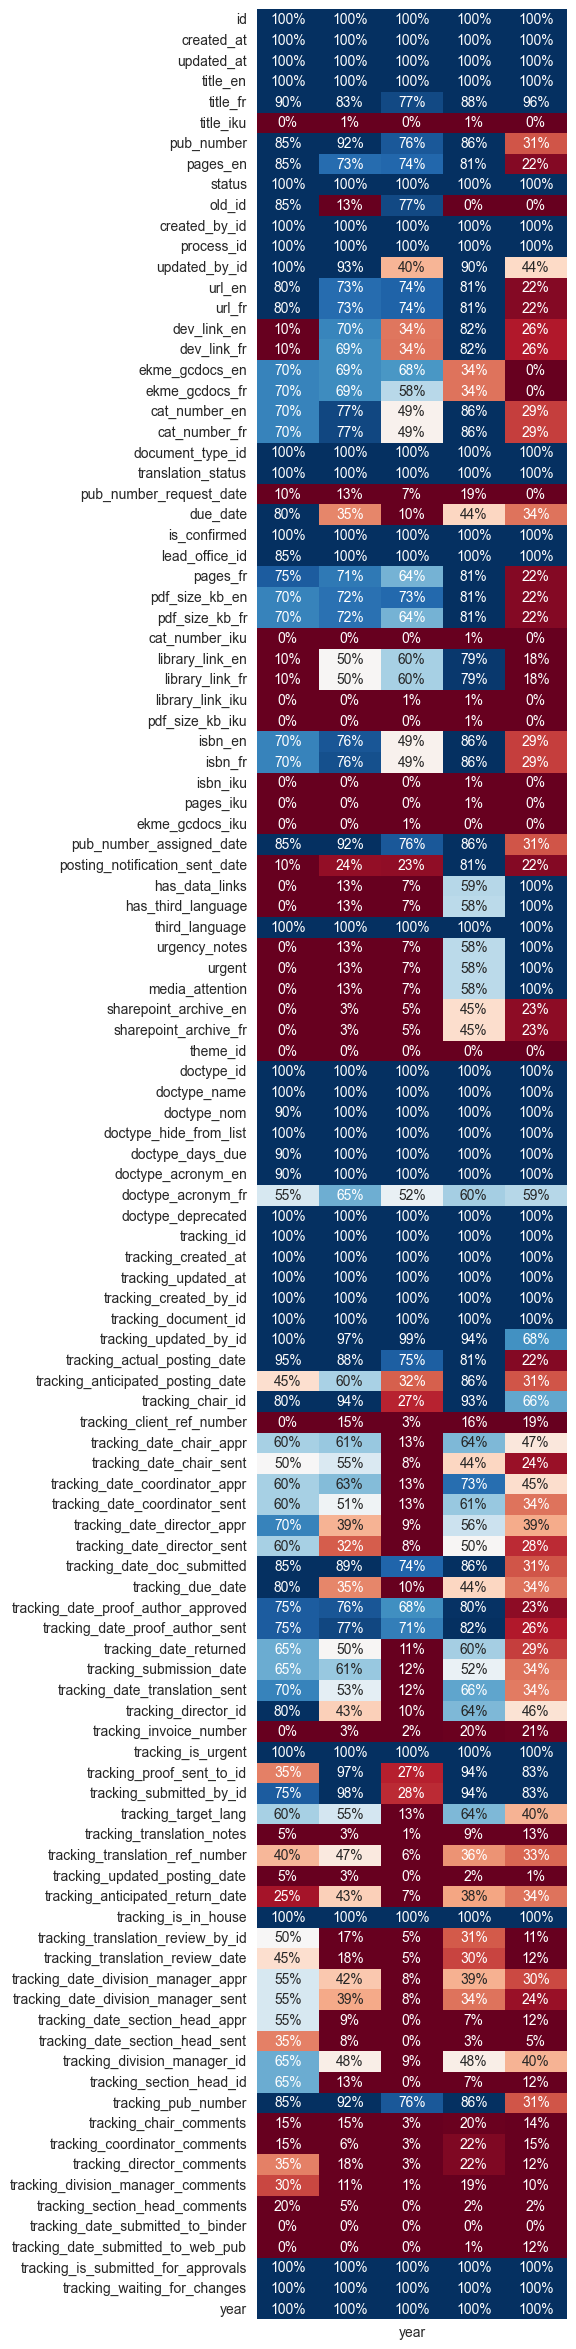

In [33]:
null_heatmap(documents, figsize=(4, 30))

# Change Log

In [34]:
# Power Users!
changelog.modified_by_id.value_counts().head(20)

modified_by_id
2359    884
1696    304
651     290
1073    262
597     244
292     221
2260    220
1045    209
3650    190
1430    185
456     173
2440    142
3286    101
2183    100
467      94
2255     85
454      85
576      77
2432     71
1647     68
Name: count, dtype: int64

In [35]:
changelog_counts = Counter()
ignore_original = True

for _, row in changelog.iterrows():
    if not ignore_original:
        original = stringify_json_values(row.original)
        keys_original = original.keys() if original else None
        if keys_original:
            for field in keys_original:
                changelog_counts[(row.model_name, field)] += 1
    changes = stringify_json_values(row.changes)
    keys_changes = changes.keys() if changes else None
    if keys_changes:
        for field in keys_changes:
            changelog_counts[(row.model_name, field)] += 1

In [36]:
changelog_counts_df = pd.DataFrame.from_records(
    [(model, field, count) for (model, field), count in changelog_counts.items()],
    columns=["model", "field", "count"]
)

### least common data entries

In [37]:
changelog_counts_df[changelog_counts_df.model == 'CSASRequest'].sort_values('count')

,model,field,count
140,CSASRequest,indigenous_consultation_details,1
137,CSASRequest,impact_assessment_tier,2
138,CSASRequest,indigenous_consultation,8
80,CSASRequest,prioritization,10
56,CSASRequest,advice_fiscal_year,13
70,CSASRequest,assistance_text,18
72,CSASRequest,rationale_for_timeline,22
82,CSASRequest,prioritization_text,47
67,CSASRequest,risk_text,68
71,CSASRequest,multiregional_text,84


In [38]:
changelog_counts_df[changelog_counts_df.model == 'Process'].sort_values('count')

,model,field,count
144,Process,in_year_rationale_fr,1
146,Process,in_year_feasibility_fr,1
142,Process,in_year_context_fr,1
141,Process,in_year_context_en,2
143,Process,in_year_rationale_en,2
145,Process,in_year_feasibility_en,2
135,Process,in_year,33
0,Process,id,99
12,Process,has_planning_meeting,99
7,Process,projects,99


In [39]:
changelog_counts_df[changelog_counts_df.model == 'TermsOfReference'].sort_values('count')

,model,field,count
136,TermsOfReference,tor_file_upload,17
14,TermsOfReference,id,99
15,TermsOfReference,meetings,155
18,TermsOfReference,expected_document_types,206
30,TermsOfReference,participation_en,208
31,TermsOfReference,participation_fr,211
29,TermsOfReference,references_fr,229
27,TermsOfReference,objectives_fr,249
28,TermsOfReference,references_en,251
26,TermsOfReference,context_fr,261


In [40]:
changelog_counts_df[changelog_counts_df.model == 'Meeting'].sort_values('count')

,model,field,count
139,Meeting,is_fsar,3
134,Meeting,media_attention,10
64,Meeting,time_description_fr,28
58,Meeting,time_description_en,42
51,Meeting,is_planning,58
50,Meeting,is_posted,58
49,Meeting,id,58
63,Meeting,chair_comments,59
47,Meeting,has_media_attention,66
48,Meeting,is_virtual,90


In [41]:
changelog_counts_df[changelog_counts_df.model == 'Document'].sort_values('count')

,model,field,count
90,Document,isbn_iku,2
91,Document,cat_number_iku,2
94,Document,title_iku,2
93,Document,pages_iku,2
97,Document,library_link_iku,2
95,Document,pdf_size_kb_iku,2
88,Document,media_attention_notes,4
89,Document,media_attention_expected,4
53,Document,ekme_gcdocs_fr,25
52,Document,ekme_gcdocs_en,26


In [42]:
changelog_counts_df[changelog_counts_df.model == 'CSASRequestReview'].sort_values('count')

,model,field,count
120,CSASRequestReview,is_valid,971
119,CSASRequestReview,notes,971
122,CSASRequestReview,new_advice,971
121,CSASRequestReview,lit_review,971
123,CSASRequestReview,is_feasible,971
124,CSASRequestReview,decision_text,971
126,CSASRequestReview,sufficient_data,971
125,CSASRequestReview,override_reason,971
129,CSASRequestReview,sufficient_capacity,971
130,CSASRequestReview,specific_advice_required,971


# SUMMARY OF COMPLIANCE ISSUES

### CSAS Reviews

In [43]:
review_noncompliance = new_reviews[~new_reviews['decision_matches_recommended']].shape[0] / new_reviews.shape[0]

print(f'Approximately {review_noncompliance:.1%} of CSAS Review decisions are inconsistent with guidelines')

Approximately 14.6% of CSAS Review decisions are inconsistent with guidelines


In [44]:
n_total = new_reviews.shape[0]
n_flagged = new_reviews[(new_reviews.decision == 2) | (new_reviews.decision == 3)].shape[0]
n_noncompliance = new_reviews[~new_reviews['decision_matches_recommended']].shape[0]

print(
    f'Out of {n_total} total CSAS Request Reviews since the new review form was implemented, '
    f'{n_noncompliance} requests ({n_noncompliance/n_total:.1%}) were screened-in while either '
    f'invalid or infeasible. \nThis is in contrast to {n_flagged} requests '
    f'({n_flagged/n_total:.1%}) that were flagged for withdrawl or re-scoping.'
)

# TODO: should this module be eliminated in favour of a dedicated Approvals Module?

Out of 212 total CSAS Request Reviews since the new review form was implemented, 31 requests (14.6%) were screened-in while either invalid or infeasible. 
This is in contrast to 16 requests (7.5%) that were flagged for withdrawl or re-scoping.


### SoMP

In [45]:
somp_noncompliance = (meetings[meetings.posting_request_date.notna()].chair_comments.isnull().sum() / 
                      meetings[meetings.posting_request_date.notna()].shape[0])

print(f'Approximately {somp_noncompliance:.1%} of posted meetings have empty chair comments field.')

Approximately 62.5% of posted meetings have empty chair comments field.


### Invitees

In [46]:
print('\nInvitees: external invitees in the app have dropped over the years\n')

pd.DataFrame(external_invitees.unstack(level=0)).mean()


Invitees: external invitees in the app have dropped over the years



year
2021   3.0
2022   1.6
2023   1.2
2024   1.2
2025   2.3
dtype: float64

In [47]:
print('\nToR: external invitees have increased in the ToR module\n')

tor[tor.status==50].groupby('year')['participant_count_external'].mean()


ToR: external invitees have increased in the ToR module



year
2021   1.8
2022   3.3
2023   0.8
2024   5.6
2025   4.8
Name: participant_count_external, dtype: float64

In [48]:
# avg_external_participants
n_external_invitees = pd.DataFrame(external_invitees.unstack(level=0)).sum().sum() / meetings.shape[0]
n_external_invitees_recently = pd.DataFrame(external_invitees[
    (external_invitees.index.get_level_values('year') == 2024) | (external_invitees.index.get_level_values('year') == 2025) 
].unstack(level=0)).sum().sum() / meetings[
    (meetings.year == 2024) | (meetings.year == 2025)
].shape[0]
n_tor_participants = tor[tor.status==50]['participant_count_external'].mean()
n_tor_participants_recently = tor[
    (tor.status==50) & ((tor.year == 2024) | (tor.year == 2025))
]['participant_count_external'].mean()

print(
    f'\nMean external invitee counts from different sources are as follows:'
    f'\n- Approximately {n_external_invitees:.1f} ({n_external_invitees_recently:.1f} recently) in the Invitee Module, '
    f'\n- Approximately {n_tor_participants:.1f} ({n_tor_participants_recently:.1f} recently) in the ToR Module, and'
    f'\n- Approximately {avg_external_participants:.1f} in the Planning Binder. '
    f'\n\nNote that "recently" means 2024 and 2025 in this case.'
)


Mean external invitee counts from different sources are as follows:
- Approximately 1.6 (1.6 recently) in the Invitee Module, 
- Approximately 2.6 (5.5 recently) in the ToR Module, and
- Approximately 8.3 in the Planning Binder. 

Note that "recently" means 2024 and 2025 in this case.


### Doc Tracking

In [49]:
# How many fields are filled out for non-default Doc Tracking

default_tracking_cols = [
    'tracking_id', 'tracking_created_at', 'tracking_updated_at', 'tracking_created_by_id', 'tracking_document_id', 'tracking_updated_by_id',
    'tracking_is_urgent', 'tracking_is_in_house', 'tracking_is_submitted_for_approvals', 'tracking_waiting_for_changes', 
]
subset = documents.iloc[:, -n_tracking:].drop(default_tracking_cols, axis=1)
tracking_noncompliance = (subset.isnull().sum().sum() / subset.size)

print(f'Approximately {tracking_noncompliance:.1%} of document tracking fields are left blank')

Approximately 76.1% of document tracking fields are left blank
